# Data Tinkering

This notebook is for finagling the [Carla data](https://github.com/asdegoyeneche/ROAR/tree/main/carla_driving_data) and seeing if we can get anything interesting out of it.

Written by Alvin Tan on 11/30/2020 for the EECS206A Final Project at UC Berkeley.

## Data Loading and Visualization

In [1]:
datapath = "pid_data_5-small_lat_lon_K.csv"

In [2]:
import pandas as pd
import numpy as np

In [3]:
dataDF = pd.read_csv(datapath, skipinitialspace=True, skiprows=2)

In [4]:
dataDF

,px,py,pz,vx,vy,vz,wpx,wpy,wpz,wvx,wvy,wvz,steering,throttle
0,8.683982,-0.006353,53.251953,-0.005046,-0.006353,-0.999987,8.659026,-0.012149,48.062115,-0.024956,-0.005796,-5.189838,0.000262,1.000000
1,8.683982,-0.006353,53.251953,-0.005046,-0.006353,-0.999987,8.659026,-0.012149,48.062115,-0.024956,-0.005796,-5.189838,0.000265,1.000000
2,8.683982,-0.006353,53.251953,-0.005046,-0.006353,-0.999987,8.659026,-0.012149,48.062115,-0.024956,-0.005796,-5.189838,0.000267,1.000000
3,8.683982,-0.006824,53.251957,-0.005046,-0.006824,-0.999987,8.659026,-0.012149,48.062115,-0.024956,-0.005325,-5.189842,0.001232,1.000000
4,8.683982,-0.006824,53.251957,-0.005046,-0.006824,-0.999987,8.659026,-0.012149,48.062115,-0.024956,-0.005325,-5.189842,0.000298,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628,11.205009,-0.006475,39.328152,-0.006013,-0.006475,-0.999982,11.163559,-0.000389,34.300083,-0.041450,0.006086,-5.028069,-0.000390,0.536765
3629,11.195711,-0.006501,37.841923,-0.006053,-0.006501,-0.999982,11.145295,-0.001637,32.725674,-0.050416,0.004864,-5.116249,-0.001017,0.692333
3630,11.176384,-0.006468,36.348759,-0.010912,-0.006468,-0.999940,11.128808,-0.002095,31.278500,-0.047576,0.004372,-5.070259,0.026800,0.648305
3631,11.176384,-0.006468,36.348759,-0.010912,-0.006468,-0.999940,11.128808,-0.002095,31.278500,-0.047576,0.004372,-5.070259,0.000379,0.495129


In [5]:
from matplotlib import pyplot as plt

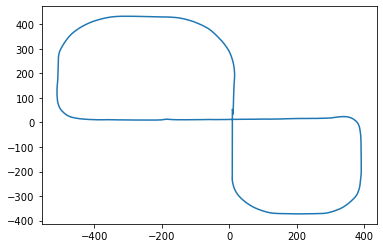

In [6]:
plt.figure()
plt.plot(dataDF['px'], dataDF['pz'])
plt.show()

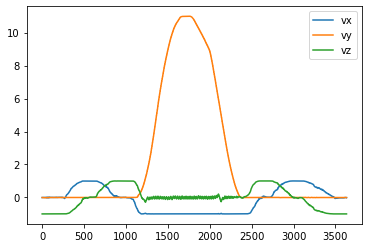

In [7]:
plt.figure()
plt.plot(dataDF['vx'], label='vx')
plt.plot(dataDF['vy'], label='vy')
plt.plot(dataDF['vz'], label='vz')
plt.legend()
plt.show()

In [8]:
dataDF['va'] = np.arctan2(dataDF['vz'], dataDF['vx'])

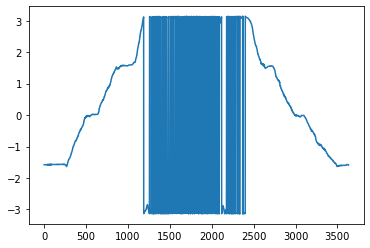

In [9]:
plt.figure()
plt.plot(dataDF['va'])
plt.show()

Based on the plot of the angle and the plot of the route, it seems like we start in the middle and then go down to start our figure 8 at $-\pi/2$. There's a lot of noise when it jumps between $-\pi$ and $\pi$, which is kind of annoying. We note that the car never goes in the $(-\pi/4, -\pi)$ direction, so maybe we can do some edgy math...

In [10]:
dataDF['va2'] = np.mod(dataDF['va'] + 3*np.pi/4, 2*np.pi) - 3*np.pi/4

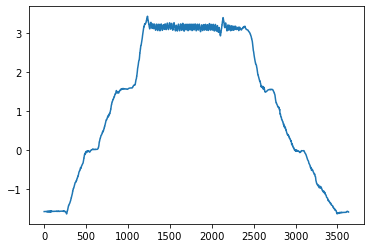

In [11]:
plt.figure()
plt.plot(dataDF['va2'])
plt.show()

Gorgeous. Not really sure why it squiggles around so much at the top. That might be where the car is going uphill and swerving all over the place. Actually yeah, that's definitely what is happening there.

In [12]:
dataDF['v'] = np.linalg.norm([dataDF['vx'], dataDF['vz']], axis=0)

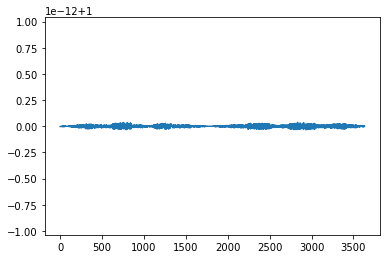

In [13]:
plt.figure()
plt.plot(dataDF['v'])
plt.show()

Interesting... so the horizontal velocity seems to be normalized to 1, which is rather unfortunate, because that doesn't actually tell me what the speed is. Uhm... In that case, we may have to do it manually.

In [14]:
# first derivatives of x, y, z, and angle
# note we assume 0.03 seconds between each sample, given by the simulator
dataDF['dx'] = dataDF['px'].diff()/0.03
dataDF['dy'] = dataDF['py'].diff()/0.03
dataDF['dz'] = dataDF['pz'].diff()/0.03
dataDF['da'] = dataDF['va2'].diff()/0.03

# second derivatives
dataDF['d2x'] = dataDF['dx'].diff()/0.03
dataDF['d2y'] = dataDF['dy'].diff()/0.03
dataDF['d2z'] = dataDF['dz'].diff()/0.03
dataDF['d2a'] = dataDF['da'].diff()/0.03

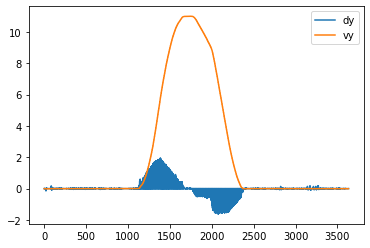

In [15]:
plt.figure()
plt.plot(dataDF['dy'], label='dy')
plt.plot(dataDF['vy'], label='vy')
plt.legend()
plt.show()

Honestly at this point I'm not very sure what vy even is anymore...

In [16]:
# velocity and acceleration in the direction of motion
dataDF['v'] = np.linalg.norm([dataDF['dx'], dataDF['dz']], axis=0)
dataDF['v2'] = np.linalg.norm([dataDF['dx'], dataDF['dy'], dataDF['dz']], axis=0)
dataDF['a'] = dataDF['v'].diff()/0.03
dataDF['a2'] = dataDF['v2'].diff()/0.03

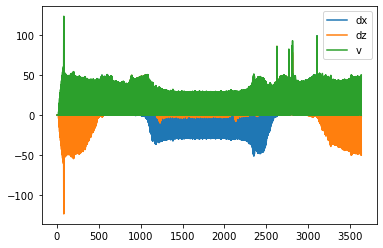

In [17]:
plt.figure()
plt.plot(dataDF['dx'], label='dx')
plt.plot(dataDF['dz'], label='dz')
plt.plot(dataDF['v'], label='v')
plt.legend()
plt.show()

Why is this so noisy smh. But it does give the correct thing, so I'm not really complaining. The speed should be around 50 km/h and dip to around 30 km/h when going uphill, which is what we kinda see here.

In [18]:
# take a rolling average across about 1 second
rollingDF = dataDF.rolling(33).mean()

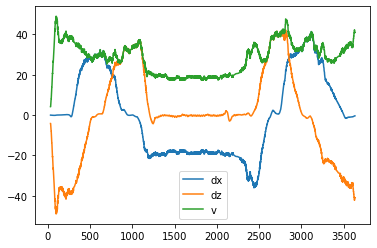

In [19]:
plt.figure()
plt.plot(rollingDF['dx'], label='dx')
plt.plot(rollingDF['dz'], label='dz')
plt.plot(rollingDF['v'], label='v')
plt.legend()
plt.show()

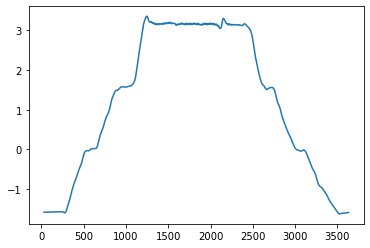

In [20]:
plt.figure()
plt.plot(rollingDF['va2'])
plt.show()

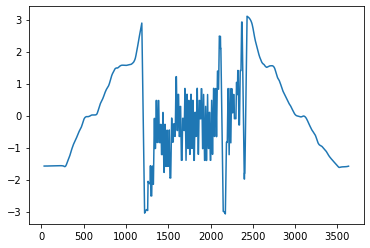

In [21]:
plt.figure()
plt.plot(rollingDF['va'])
plt.show()

Lmao I'm glad I did the scuffed angle shifting thing before taking the rolling average. But yeah, rolling average with a window of 33 seems to work pretty well.

## Data analysis

Now that the data looks pretty (or at least somewhat reasonable), let's try plotting out some relations between input and car state. I'm honestly not sure what the smoothed inputs would look like so maybe we want to use the unsmoothed data for that...

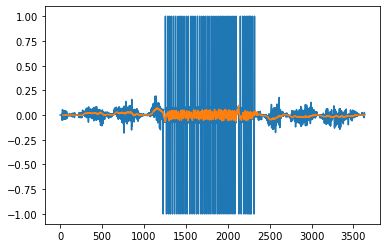

In [22]:
plt.figure()
plt.plot(dataDF['steering'])
plt.plot(rollingDF['steering'])
plt.show()

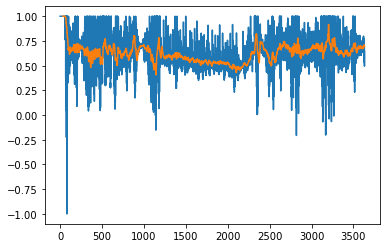

In [23]:
plt.figure()
plt.plot(dataDF['throttle'])
plt.plot(rollingDF['throttle'])
plt.show()

These are kinda gross, ngl. Anyways, intuition says that steering would change the angle you're going at, so let's try that really quick.

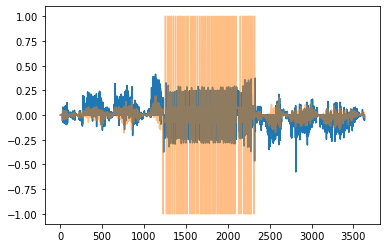

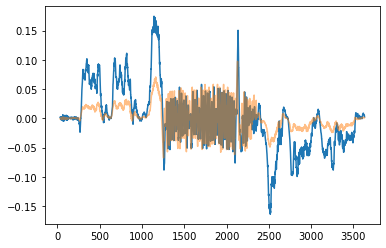

In [24]:
plt.figure()
plt.plot(dataDF['da']/np.pi)
plt.plot(dataDF['steering'], alpha=0.5)
plt.show()

plt.figure()
plt.plot(rollingDF['da']/np.pi)
plt.plot(rollingDF['steering'], alpha=0.5)
plt.show()

Looks promising...

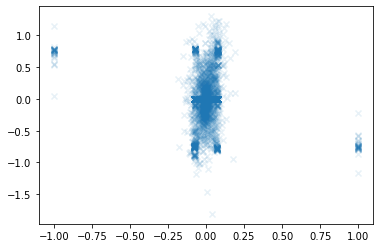

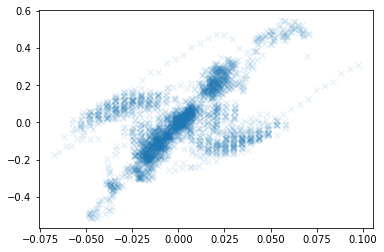

In [25]:
plt.figure()
plt.scatter(dataDF['steering'], dataDF['da'], marker='x', alpha=0.1)
plt.show()

plt.figure()
plt.scatter(rollingDF['steering'], rollingDF['da'], marker='x', alpha=0.1)
plt.show()

Lmao just kidding. Maybe the second derivative?

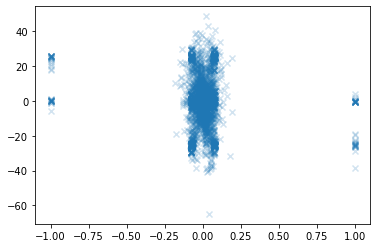

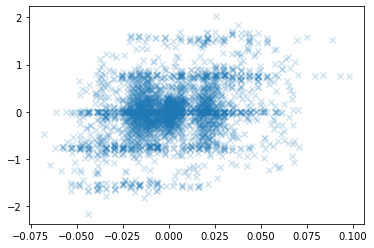

In [26]:
plt.figure()
plt.scatter(dataDF['steering'], dataDF['d2a'], marker='x', alpha=0.2)
plt.show()

plt.figure()
plt.scatter(rollingDF['steering'], rollingDF['d2a'], marker='x', alpha=0.2)
plt.show()

Mm nah that's even worse. I'm guessing there's generally a linear relation between steering and angular velocity, but sometimes when the car is going uphill or something, it gets harder to control using the steering? It seems like the smoothed data is actually pretty helpful here, though, so I think we can just use that for our analysis.

Now, onto throttle v.s. speed

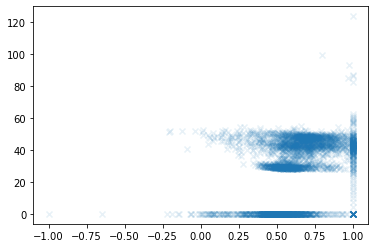

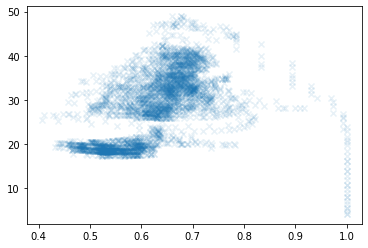

In [27]:
plt.figure()
plt.scatter(dataDF['throttle'], dataDF['v'], marker='x', alpha=0.1)
plt.show()

plt.figure()
plt.scatter(rollingDF['throttle'], rollingDF['v'], marker='x', alpha=0.1)
plt.show()

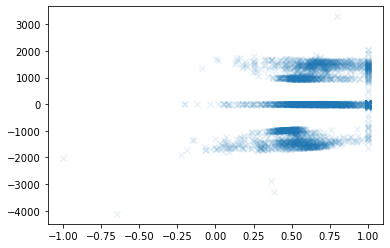

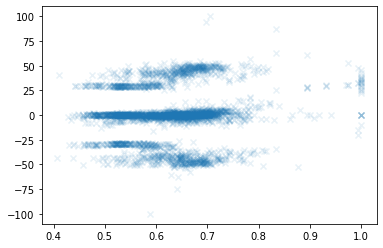

In [28]:
plt.figure()
plt.scatter(dataDF['throttle'], dataDF['a'], marker='x', alpha=0.1)
plt.show()

plt.figure()
plt.scatter(rollingDF['throttle'], rollingDF['a'], marker='x', alpha=0.1)
plt.show()

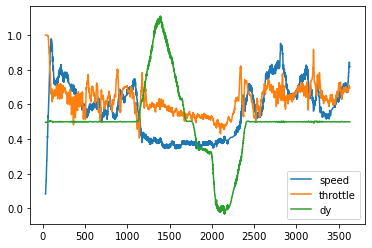

In [29]:
plt.figure()
plt.plot(rollingDF['v']/50, label='speed')
plt.plot(rollingDF['throttle'], label='throttle')
plt.plot((rollingDF['dy'] + 1)/2, label='dy')
plt.legend()
plt.show()

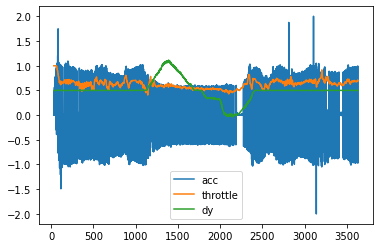

In [30]:
plt.figure()
plt.plot(rollingDF['a']/50, label='acc')
plt.plot(rollingDF['throttle'], label='throttle')
plt.plot((rollingDF['dy'] + 1)/2, label='dy')
plt.legend()
plt.show()

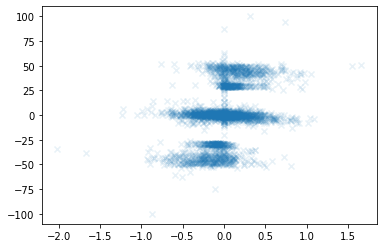

In [31]:
plt.figure()
plt.scatter(rollingDF['throttle'].diff()/0.03, rollingDF['a'], marker='x', alpha=0.1)
plt.show()

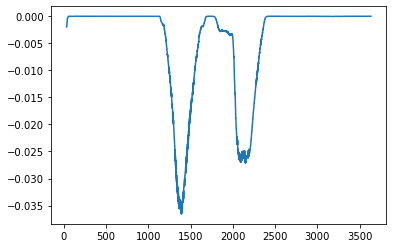

In [32]:
plt.figure()
plt.plot(rollingDF['v'] - rollingDF['v2'])
plt.show()

Is there a relation? Honestly it is so hard to tell... Seems like there should be though... What are we trying to do here? Find a linear relation between throttle and speed? A linear relation between steering and angular velocity? Acceleration is so jumpy it doesn't seem like we'll get anything useful out of it.

So that gives us a state with angle, angular velocity, and linear velocity, and possible inputs of steering and throttle. I wonder if we can do a massive matrix division here...

## Data modeling

Big boi regression coming in hot. 

In [33]:
from sklearn.linear_model import LinearRegression as lr

In [34]:
cleanDF = rollingDF.dropna()

In [93]:
# regression for angle
X = cleanDF[['va2', 'da', 'v', 'throttle', 'steering']].to_numpy()[:-1]

In [94]:
theta = cleanDF['va2'].to_numpy()[1:]

In [95]:
theta_reg = lr().fit(X, theta)

In [96]:
theta_reg.score(X, theta)

0.9999999427511872

In [97]:
theta_reg.coef_

array([ 9.99976441e-01,  2.87500249e-02, -6.06685238e-07, -3.37912605e-04,
        1.38015075e-02])

In [98]:
theta_reg.intercept_

0.00024767738758102453

In [99]:
# regression for angular velocity
ang_vel = cleanDF['da'].to_numpy()[1:]
ang_vel_reg = lr().fit(X, ang_vel)

In [100]:
ang_vel_reg.score(X, ang_vel)

0.9922523016348175

In [101]:
ang_vel_reg.coef_

array([-7.85298017e-04,  9.58334162e-01, -2.02228413e-05, -1.12637535e-02,
        4.60050249e-01])

In [102]:
ang_vel_reg.intercept_

0.008255912919486425

In [103]:
# regression for linear velocity
vel = cleanDF['v'].to_numpy()[1:]
vel_reg = lr().fit(X, vel)

In [104]:
vel_reg.score(X, vel)

0.9902115615021994

In [105]:
vel_reg.coef_

array([-0.02717828, -0.08111844,  0.98504246,  0.86622527, -0.27129561])

In [106]:
vel_reg.intercept_

-0.07332160337038829

Tbh this seems kind of scuffed, but it looks like the angle depends mainly on current angle and steering (which is to be expected), angular velocity depends mainly on current anglular velocity (and a bit on steering), and linear velocity depends on current velocity, increases with throttle, and decreases with steering and turning (which also makes sense?). There seems to be nonzero intercepts for all of the regressions, though, which I don't think we want, but can be easily accounted for by tacking a 1 at the bottom of our state vector.

In [107]:
# do the same thing again, but with statsmodel because I like their summary
import statsmodels.api as sm

In [108]:
X1 = sm.add_constant(X)

In [109]:
theta_mod = sm.OLS(theta, X1)
theta_res = theta_mod.fit()
theta_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.255e+10
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:22:47   Log-Likelihood:                 22807.
No. Observations:                3598   AIC:                        -4.560e+04
Df Residuals:                    3592   BIC:                        -4.557e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   7.25e-05      3.416      0.001       0.000       0.000
x1             1.0000   5.68e-06   1.76e+05      0.000       1.000       1.000
x2             0.0288   5.44e-05    528.334      0.000       0.029       0.029
x3         -6.067e-07   1.25e-06     -0.484      0.628   -3.06e-06    1.85e-06
x4            -0.0003      0.000     -3.278      0.001      -0.001      -0.000
x5             0.0138      0.000     35.080      0.000       0.013       0.015
==============================================================================
Omnibus:                      154.275   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              501.780
Skew:                          -0.042   Prob(JB):                    1.10e-109
Kurtosis:                       4.828   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There's probably strong multicollinearity between steering and angular velocity. Let's just remove angular velocity from our states and do the regressions again.

In [110]:
X = cleanDF[['va2', 'v', 'throttle', 'steering']].iloc[:-1]

In [111]:
X = sm.add_constant(X)

In [112]:
theta_mod = sm.OLS(theta, X)
theta_res = theta_mod.fit()
theta_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.993e+08
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:23:10   Log-Likelihood:                 14953.
No. Observations:                3598   AIC:                        -2.990e+04
Df Residuals:                    3593   BIC:                        -2.987e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.001     10.158      0.000       0.005       0.008
va2            0.9996   4.99e-05      2e+04      0.000       0.999       1.000
v          -8.402e-05    1.1e-05     -7.617      0.000      -0.000   -6.24e-05
throttle      -0.0058      0.001     -6.340      0.000      -0.008      -0.004
steering       0.1302      0.003     45.035      0.000       0.125       0.136
==============================================================================
Omnibus:                       30.714   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.657
Skew:                          -0.089   Prob(JB):                     1.20e-05
Kurtosis:                       2.655   Cond. No.                     1.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Lmao I'm dumb. The strong multicollinearity comes from the previous state being in the regression. In that case, let's just do the thing with all three state values.

In [113]:
X = cleanDF[['va2', 'da', 'v', 'throttle', 'steering']].iloc[:-1]
X = sm.add_constant(X)

In [114]:
theta_mod = sm.OLS(theta, X)
theta_res = theta_mod.fit()
theta_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.255e+10
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:23:42   Log-Likelihood:                 22807.
No. Observations:                3598   AIC:                        -4.560e+04
Df Residuals:                    3592   BIC:                        -4.557e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   7.25e-05      3.416      0.001       0.000       0.000
va2            1.0000   5.68e-06   1.76e+05      0.000       1.000       1.000
da             0.0288   5.44e-05    528.334      0.000       0.029       0.029
v          -6.067e-07   1.25e-06     -0.484      0.628   -3.06e-06    1.85e-06
throttle      -0.0003      0.000     -3.278      0.001      -0.001      -0.000
steering       0.0138      0.000     35.080      0.000       0.013       0.015
==============================================================================
Omnibus:                      154.275   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              501.780
Skew:                          -0.042   Prob(JB):                    1.10e-109
Kurtosis:                       4.828   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
ang_vel_mod = sm.OLS(ang_vel, X)
ang_vel_res = ang_vel_mod.fit()
ang_vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 9.201e+04
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:23:49   Log-Likelihood:                 10191.
No. Observations:                3598   AIC:                        -2.037e+04
Df Residuals:                    3592   BIC:                        -2.033e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.002      3.416      0.001       0.004       0.013
va2           -0.0008      0.000     -4.149      0.000      -0.001      -0.000
da             0.9583      0.002    528.334      0.000       0.955       0.962
v          -2.022e-05   4.18e-05     -0.484      0.628      -0.000    6.17e-05
throttle      -0.0113      0.003     -3.278      0.001      -0.018      -0.005
steering       0.4601      0.013     35.080      0.000       0.434       0.486
==============================================================================
Omnibus:                      154.275   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              501.780
Skew:                          -0.042   Prob(JB):                    1.10e-109
Kurtosis:                       4.828   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [116]:
vel_mod = sm.OLS(vel, X)
vel_res = vel_mod.fit()
vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 7.267e+04
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:23:52   Log-Likelihood:                -4155.4
No. Observations:                3598   AIC:                             8323.
Df Residuals:                    3592   BIC:                             8360.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0733      0.130     -0.563      0.574      -0.329       0.182
va2           -0.0272      0.010     -2.664      0.008      -0.047      -0.007
da            -0.0811      0.098     -0.830      0.407      -0.273       0.111
v              0.9850      0.002    437.356      0.000       0.981       0.989
throttle       0.8662      0.185      4.677      0.000       0.503       1.229
steering      -0.2713      0.707     -0.384      0.701      -1.657       1.115
==============================================================================
Omnibus:                        0.958   Durbin-Watson:                   2.779
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.942
Skew:                           0.040   Prob(JB):                        0.624
Kurtosis:                       3.006   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Cool, so now we have our A and B matrices! Should we zero out everything that isn't statistically significant? Or should we just use all the values anyways? Maybe we can try both?

In [117]:
# taking out variables that are not statistically significant
X = cleanDF[['va2', 'da', 'steering']].iloc[:-1]
theta_mod = sm.OLS(theta, X)
theta_res = theta_mod.fit()
theta_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.044e+10
Date:                Wed, 02 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:25:00   Log-Likelihood:                          22801.
No. Observations:                3598   AIC:                                 -4.560e+04
Df Residuals:                    3595   BIC:                                 -4.558e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
va2            1.0000   3.31e-06   3.02e+05      0.000       1.000       1.000
da             0.0288   5.36e-05    536.656      0.000       0.029       0.029
steering       0.0138      0.000     35.002      0.000       0.013       0.015
==============================================================================
Omnibus:                      151.484   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.025
Skew:                           0.001   Prob(JB):                    2.37e-107
Kurtosis:                       4.810   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
X = cleanDF[['da', 'steering']].iloc[:-1]
ang_vel_mod = sm.OLS(ang_vel, X)
ang_vel_res = ang_vel_mod.fit()
ang_vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          2.287e+05
Date:                Wed, 02 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:25:04   Log-Likelihood:                          10178.
No. Observations:                3598   AIC:                                 -2.035e+04
Df Residuals:                    3596   BIC:                                 -2.034e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
da             0.9594      0.002    536.192      0.000       0.956       0.963
steering       0.4571      0.013     34.813      0.000       0.431       0.483
==============================================================================
Omnibus:                      155.813   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              488.745
Skew:                          -0.098   Prob(JB):                    7.42e-107
Kurtosis:                       4.795   Cond. No.                         8.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
X = cleanDF[['v', 'throttle']].iloc[:-1]
X = sm.add_constant(X)
vel_mod = sm.OLS(vel, X)
vel_res = vel_mod.fit()
vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.814e+05
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:25:08   Log-Likelihood:                -4159.4
No. Observations:                3598   AIC:                             8325.
Df Residuals:                    3595   BIC:                             8343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3186      0.095     -3.340      0.001      -0.506      -0.132
v              0.9885      0.002    523.290      0.000       0.985       0.992
throttle       1.0503      0.173      6.072      0.000       0.711       1.389
==============================================================================
Omnibus:                        0.712   Durbin-Watson:                   2.785
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.708
Skew:                           0.034   Prob(JB):                        0.702
Kurtosis:                       2.999   Cond. No.                         443.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
X = cleanDF[['v', 'throttle']].iloc[:-1]
vel_mod = sm.OLS(vel, X)
vel_res = vel_mod.fit()
vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.635e+06
Date:                Wed, 02 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:25:11   Log-Likelihood:                         -4165.0
No. Observations:                3598   AIC:                                      8334.
Df Residuals:                    3596   BIC:                                      8346.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v              0.9884      0.002    522.548      0.000       0.985       0.992
throttle       0.5533      0.088      6.266      0.000       0.380       0.726
==============================================================================
Omnibus:                        2.326   Durbin-Watson:                   2.770
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.326
Skew:                           0.062   Prob(JB):                        0.312
Kurtosis:                       2.994   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Other plotting

I realized I have not done anything with the waypoint information, so let's just plot some of it to see what it looks like

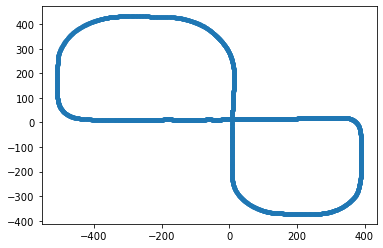

In [63]:
plt.figure()
plt.scatter(rollingDF['wpx'], rollingDF['wpz'], marker='.')
plt.show()

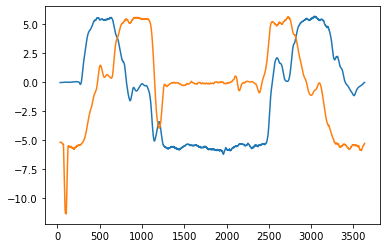

In [64]:
plt.figure()
plt.plot(rollingDF['wvx'])
plt.plot(rollingDF['wvz'])
plt.show()

In [65]:
dataDF['wva'] = np.arctan2(dataDF['wvz'], dataDF['wvx'])
dataDF['wva2'] = np.mod(dataDF['wva'] + 3*np.pi/4, 2*np.pi) - 3*np.pi/4
rollingDF = dataDF.rolling(33).mean()

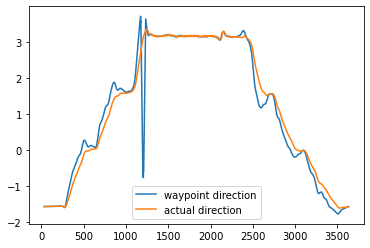

In [66]:
plt.figure()
plt.plot(rollingDF['wva2'], label='waypoint direction')
plt.plot(rollingDF['va2'], label='actual direction')
plt.legend()
plt.show()

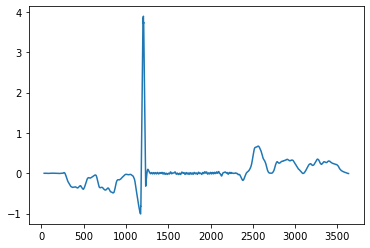

In [67]:
plt.figure()
plt.plot(rollingDF['va2'] - rollingDF['wva2'])
plt.show()

Funky. Seems like waypoint direction is kinda bouncy for some reason, and the error in angle isn't the nice dampened sinusoid that we want to see. Rather unfortunate. Also, it seems like it tries to go to a waypoint that is behind itself (at ~1200)? That's rather strange...

# Discrete Time LQR

Time to do the actual thing now. We use an A and B as calculated from the work above.

In [68]:
A = np.array([[0.9922, -0.2606, 0.0   ],
              [0.0,     0.9594, 0.0   ],
              [0.0,     0.0,    0.9884]])

B = np.array([[0.0,    1.6550],
              [0.0,    0.4571],
              [0.5533, 0.0   ]])

In [69]:
from scipy.linalg import solve_discrete_are as are

In [70]:
# solves the infinite-horizon discrete-time lqr controller
def dlqr(A, B, Q, R):
    # solve the ricatti equation for P
    P = are(A, B, Q, R)
    
    # K = (B.T P B + R)^-1 (B.T P A)
    K = np.linalg.multi_dot([np.linalg.inv(np.linalg.multi_dot([B.T, P, B]) + R), B.T, P, A])
    
    return P, K

In [71]:
# Try some Q and R values
Q = 1 * np.eye(3)
R = 1 * np.eye(2)

In [72]:
# Calculate the P and K matrices
P, K = dlqr(A, B, Q, R)

In [73]:
P

array([[ 4.23776534e+01, -1.56283987e+02,  7.23115879e-15],
       [-1.56283987e+02,  5.94783845e+02, -2.77988413e-14],
       [ 7.23115879e-15, -2.77988413e-14,  2.32786289e+00]])

In [74]:
K

array([[ 2.25480327e-15, -8.58871271e-15,  7.43329153e-01],
       [-2.64260581e-01,  2.66423862e+00, -8.72497774e-17]])

In [75]:
x0 = np.array([1.0, 0.05, 50])

In [76]:
# try a simulation?
x = [x0]
u = []
xt = x0

# simulate 2 seconds
for i in range(66):
    # clip inputs to be on [-1, 1]
    ut = -np.dot(K, xt)
    ut = np.clip(ut, -1, 1)
    
    xt = np.dot(A, xt) + np.dot(B, ut)
    x.append(xt)
    u.append(ut)
    
x = np.array(x)
u = np.array(u)

In [77]:
def plot_simulation(x, u):
    plt.figure(figsize=(15, 15))


    plt.subplot(321)
    plt.title('angle')
    plt.plot(x[:, 0], label='angle')

    plt.subplot(323)
    plt.title('angular velocity')
    plt.plot(x[:, 1], label='angular velocity')

    plt.subplot(325)
    plt.title('linear velocity')
    plt.plot(x[:, 2], label='linear velocity')


    plt.subplot(322)
    plt.title('throttle')
    plt.plot(u[:, 0], label='throttle')

    plt.subplot(324)
    plt.title('steering')
    plt.plot(u[:, 1])


    plt.show()

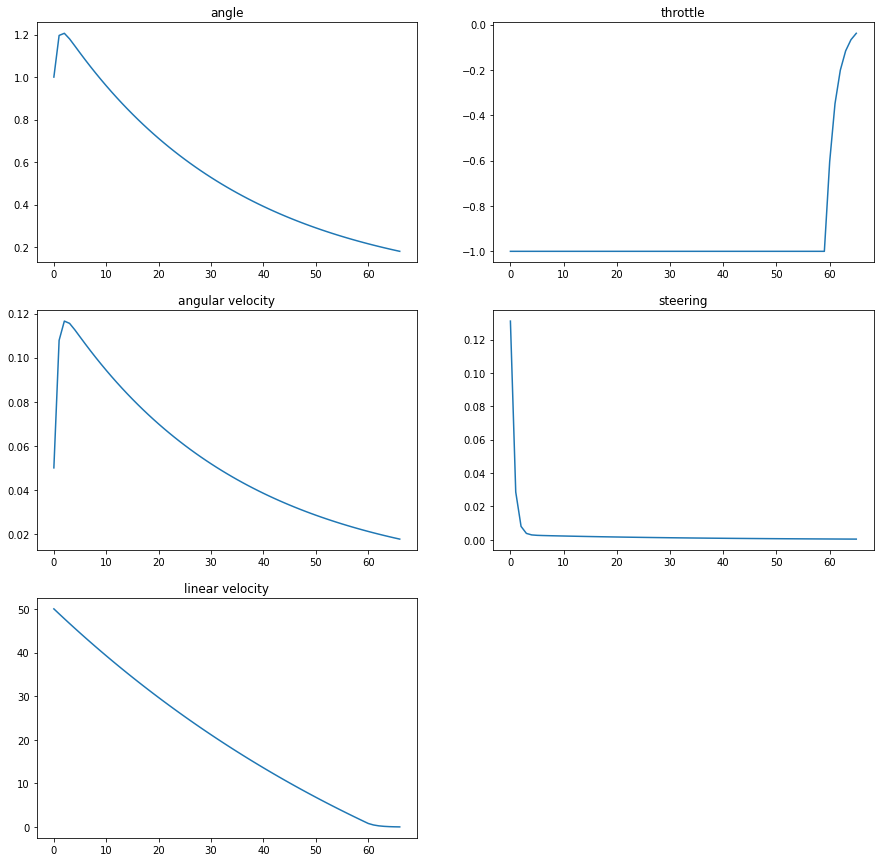

In [78]:
plot_simulation(x, u)

Seems like it's working well enough. How do we get it to follow some desired trajectory?

In [79]:
xd = np.array([np.pi/2, 0, 45])
ud,_,_,_ = np.linalg.lstsq(B, xd - np.dot(A, xd), rcond=None)

In [80]:
xd

array([ 1.57079633,  0.        , 45.        ])

In [81]:
ud

array([0.94343033, 0.00687844])

Looks like we have to keep throttle pretty high to maintain a constant velocity. Does this seem reasonable? Probably not... Maybe the linear fit was kind of funky... Anyways, let's run a simulation

In [82]:
# try a simulation
x0 = np.array([1.0, 0.05, 50])
xt = x0

x = [x0]
u = []

# simulate 2 seconds
for i in range(66):
    # convert to offset variables zt and ht
    zt = xt - xd
    ht = -np.dot(K, zt)
    
    # convert back to xt and ut, clip inputs to be on [-1, 1], and take a step
    ut = np.clip(ht+ud, -1, 1)
    xt = np.dot(A, xt) + np.dot(B, ut)
    
    x.append(xt)
    u.append(ut)
    
x = np.array(x)
u = np.array(u)

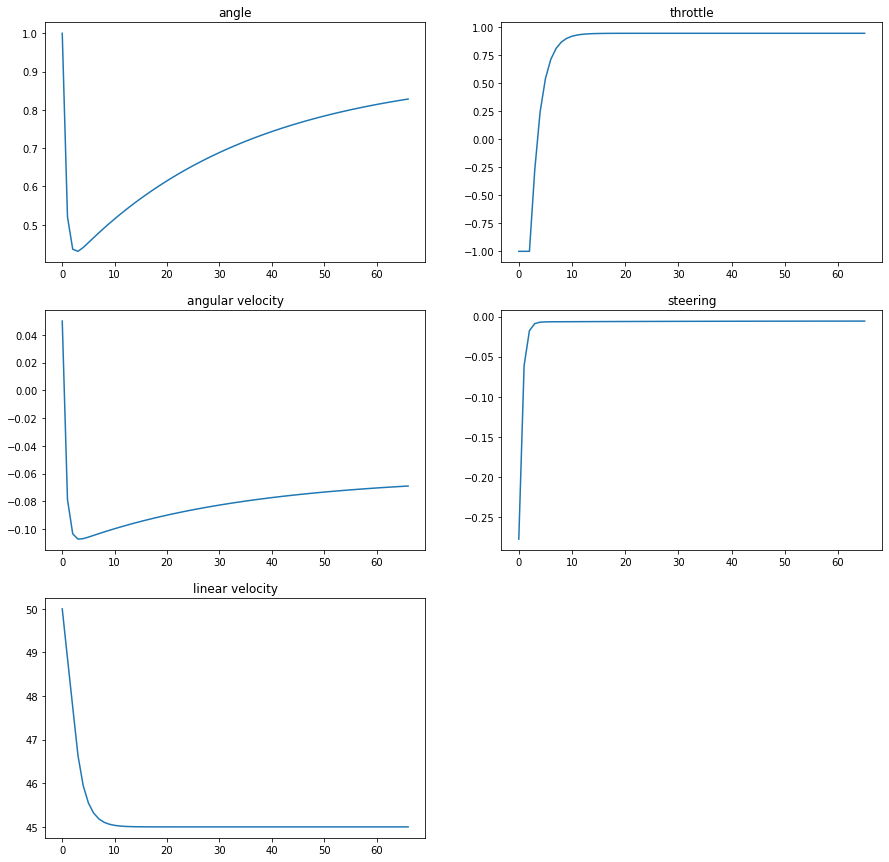

In [83]:
plot_simulation(x, u)

The throttle seems to work well enough but the angle is nowhere close to 1.57? Would it get closer if we let it go for longer?

In [86]:
# function to simulate stuff
def simulate_control(A, B, K, x0, xd=np.zeros((3,)), num_steps=66):
    # calculate a system-viable ud assuming constant xd
    ud,_,_,_ = np.linalg.lstsq(B, xd - np.dot(A, xd), rcond=None)
    
    # run our simulation
    x = [x0]
    u = []
    
    xt = x0
    for i in range(num_steps):
        # convert to offset variables zt and ht
        zt = xt - xd
        ht = -np.dot(K, zt)
        #ut = -np.dot(K, zt)

        # convert back to xt and ut, clip inputs to be on [-1, 1], and take a step
        ut = np.clip(ht+ud, -1, 1)
        #breakpoint()
        xt = np.dot(A, xt) + np.dot(B, ut)

        x.append(xt)
        u.append(ut)

    x = np.array(x)
    u = np.array(u)
    
    return x, u

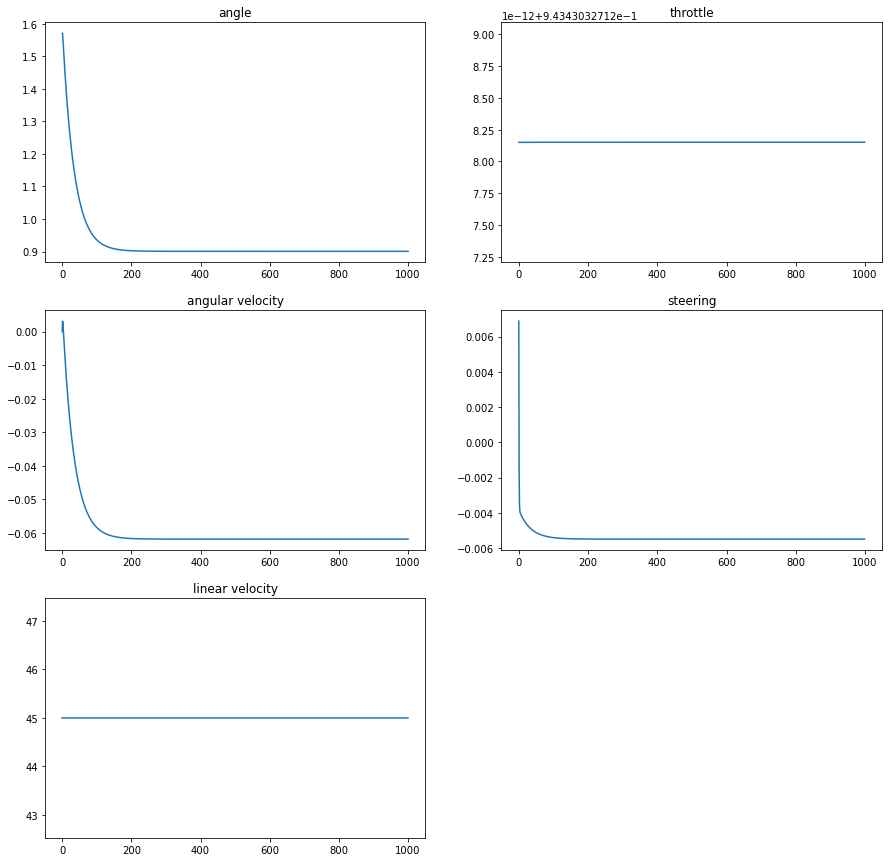

In [87]:
xd = np.array([np.pi/2, 0, 45])
x0 = xd #np.array([1.0, 0.5, 50])

x, u = simulate_control(A, B, K, x0, xd, num_steps=1000)
plot_simulation(x, u)

I am so confused why this isn't working for the angle??

## Day 2 (12/02/2020)

Back at it again!

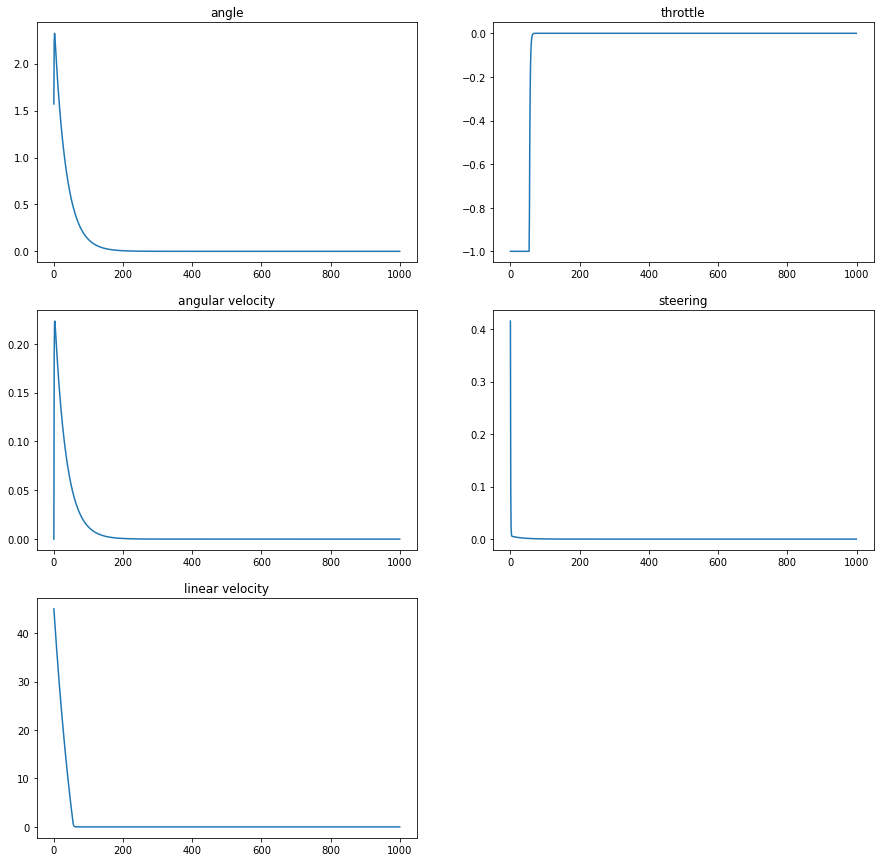

In [88]:
x, u = simulate_control(A, B, K, x0, num_steps=1000)
plot_simulation(x, u)

So the first thing I want to do is make a new model and test some other data with it, too. I don't think we need angular velocity at all, and we probably just have direct linear relations between angular velocity and steering, and linear velocity and throttle, so I don't know if we actually need the bulk of the LQR? Like it's just a system with two-dimensional state and two-dimensional inputs...

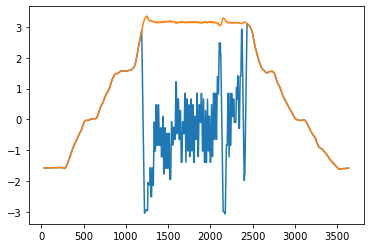

In [121]:
# also, just realized that va2 is the clean angle value and I had been using 
# va in the first few regressions I've been running. I am so sad
plt.figure()
plt.plot(cleanDF['va'])
plt.plot(cleanDF['va2'])
plt.show()

In [122]:
# just doing a one-to-one relation with a constant offset
X = cleanDF[['va2', 'steering']].iloc[:-1]
X = sm.add_constant(X)
theta_mod = sm.OLS(theta, X)
theta_res = theta_mod.fit()
theta_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.858e+08
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:28:40   Log-Likelihood:                 14893.
No. Observations:                3598   AIC:                        -2.978e+04
Df Residuals:                    3595   BIC:                        -2.976e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.099e-05   7.77e-05     -0.270      0.787      -0.000       0.000
va2            0.9999    3.6e-05   2.78e+04      0.000       1.000       1.000
steering       0.1339      0.003     45.890      0.000       0.128       0.140
==============================================================================
Omnibus:                       35.669   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.051
Skew:                           0.119   Prob(JB):                     1.34e-06
Kurtosis:                       2.648   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
X = cleanDF[['v', 'da', 'throttle']].iloc[:-1]
X = sm.add_constant(X)
vel_mod = sm.OLS(vel, X)
vel_res = vel_mod.fit()
vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.209e+05
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:30:50   Log-Likelihood:                -4159.0
No. Observations:                3598   AIC:                             8326.
Df Residuals:                    3594   BIC:                             8351.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3085      0.096     -3.209      0.001      -0.497      -0.120
v              0.9883      0.002    520.956      0.000       0.985       0.992
da            -0.0698      0.080     -0.870      0.384      -0.227       0.087
throttle       1.0409      0.173      6.006      0.000       0.701       1.381
==============================================================================
Omnibus:                        0.882   Durbin-Watson:                   2.785
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.876
Skew:                           0.038   Prob(JB):                        0.645
Kurtosis:                       3.000   Cond. No.                         445.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
X = cleanDF[['v', 'throttle']].iloc[:-1]
X = sm.add_constant(X)
vel_mod = sm.OLS(vel, X)
vel_res = vel_mod.fit()
vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.814e+05
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:31:05   Log-Likelihood:                -4159.4
No. Observations:                3598   AIC:                             8325.
Df Residuals:                    3595   BIC:                             8343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3186      0.095     -3.340      0.001      -0.506      -0.132
v              0.9885      0.002    523.290      0.000       0.985       0.992
throttle       1.0503      0.173      6.072      0.000       0.711       1.389
==============================================================================
Omnibus:                        0.712   Durbin-Watson:                   2.785
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.708
Skew:                           0.034   Prob(JB):                        0.702
Kurtosis:                       2.999   Cond. No.                         443.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
X = cleanDF[['v', 'throttle']].iloc[:-1]
vel_mod = sm.OLS(vel, X)
vel_res = vel_mod.fit()
vel_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.635e+06
Date:                Wed, 02 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:32:37   Log-Likelihood:                         -4165.0
No. Observations:                3598   AIC:                                      8334.
Df Residuals:                    3596   BIC:                                      8346.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v              0.9884      0.002    522.548      0.000       0.985       0.992
throttle       0.5533      0.088      6.266      0.000       0.380       0.726
==============================================================================
Omnibus:                        2.326   Durbin-Watson:                   2.770
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.326
Skew:                           0.062   Prob(JB):                        0.312
Kurtosis:                       2.994   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So turns out that the current angle/velocity is a very good predictor for the angle/velocity 0.03 seconds from now. Who would have thought! Maybe I should make the period an entire second...

In [128]:
# from the above
A = np.array([[0.9999, 0.0],
              [0.0,    0.9884]])

B = np.array([[0.1339, 0.0],
              [0.0,    0.5533]])

In [134]:
# let's prioritize accurate angle over accurate speed
Q = np.diag([1, 0.5])
R = np.diag([1, 1])

In [137]:
P, K = dlqr(A, B, Q, R)

In [138]:
P

array([[7.97903098, 0.        ],
       [0.        , 1.50782802]])

In [140]:
K

array([[0.93458571, 0.        ],
       [0.        , 0.56417568]])

In [145]:
# function to simulate stuff
def simulate_control_2D(A, B, K, x0, xd=np.zeros((2,)), num_steps=66):
    # calculate a system-viable ud assuming constant xd
    ud,_,_,_ = np.linalg.lstsq(B, xd - np.dot(A, xd), rcond=None)
    
    # run our simulation
    x = [x0]
    u = []
    
    xt = x0
    for i in range(num_steps):
        # convert to offset variables zt and ht
        zt = xt - xd
        ht = -np.dot(K, zt)
        #ut = -np.dot(K, zt)

        # convert back to xt and ut, clip inputs to be on [-1, 1], and take a step
        ut = np.clip(ht+ud, -1, 1)
        #breakpoint()
        xt = np.dot(A, xt) + np.dot(B, ut)

        x.append(xt)
        u.append(ut)

    x = np.array(x)
    u = np.array(u)
    
    return x, u

In [148]:
def plot_simulation_2D(x, u):
    plt.figure(figsize=(15, 15))


    plt.subplot(221)
    plt.title('direction')
    plt.plot(x[:, 0], label='angle')

    plt.subplot(223)
    plt.title('speed')
    plt.plot(x[:, 1], label='angular velocity')


    plt.subplot(222)
    plt.title('steering')
    plt.plot(u[:, 0], label='throttle')

    plt.subplot(224)
    plt.title('throttle')
    plt.plot(u[:, 1])


    plt.show()

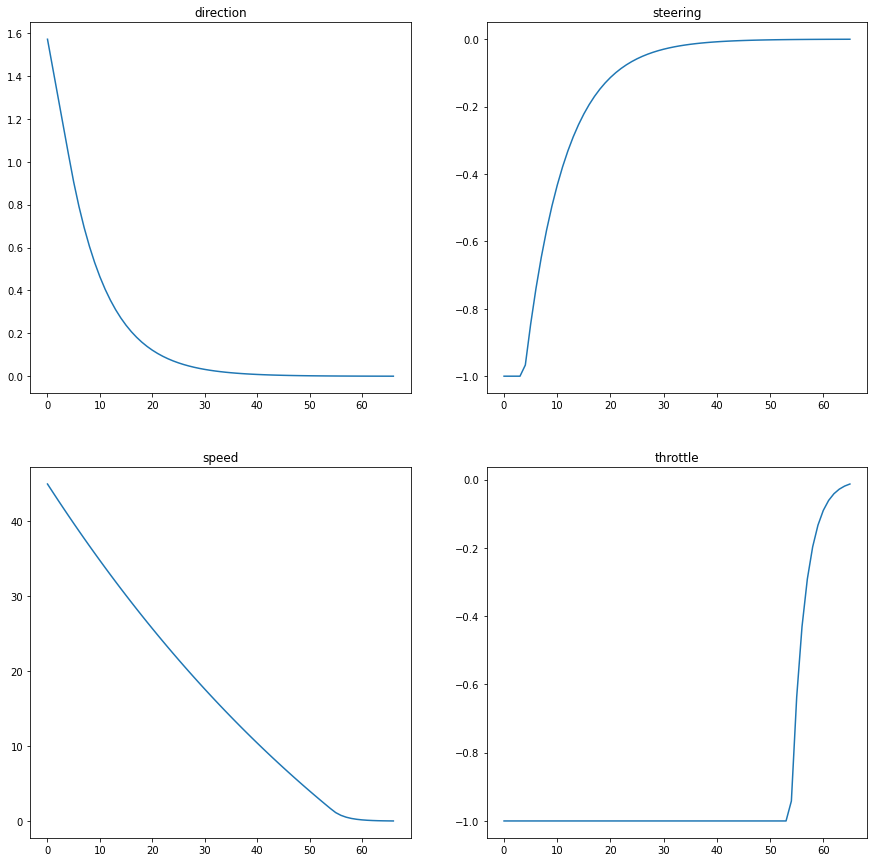

In [149]:
x0 = np.array([np.pi/2, 45])
xd = np.zeros((2,))

x, u = simulate_control_2D(A, B, K, x0)
plot_simulation_2D(x, u)

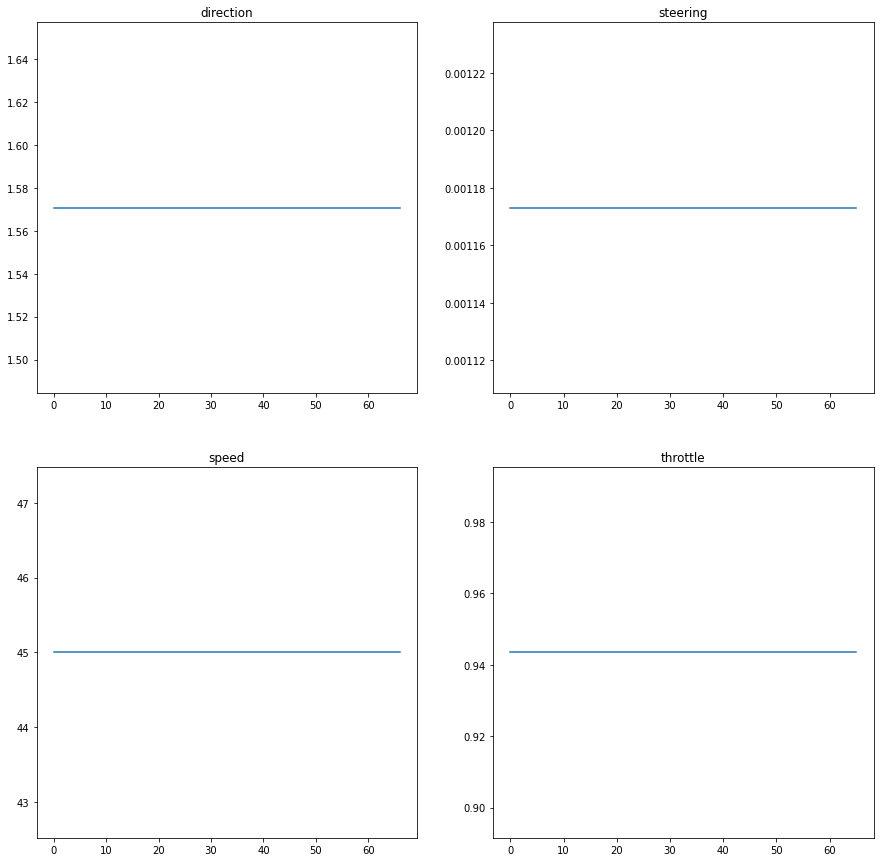

In [150]:
x0 = np.array([np.pi/2, 45])
xd = x0

x, u = simulate_control_2D(A, B, K, x0, xd)
plot_simulation_2D(x, u)

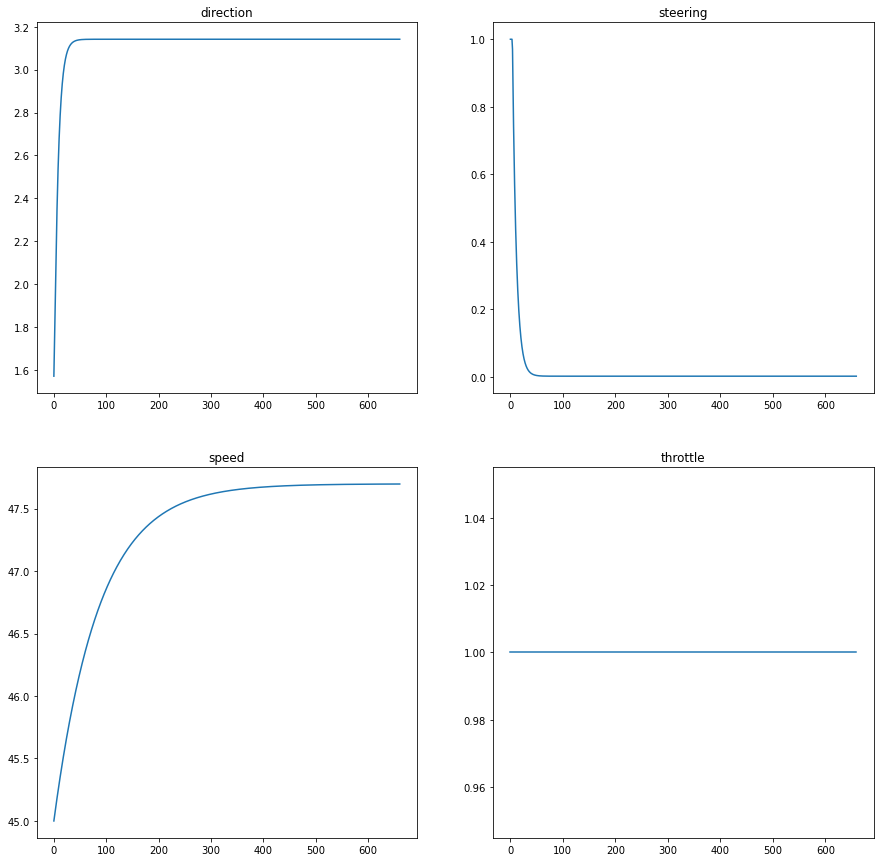

In [154]:
x0 = np.array([np.pi/2, 45])
xd = np.array([np.pi, 50])

x, u = simulate_control_2D(A, B, K, x0, xd, num_steps=660)
plot_simulation_2D(x, u)

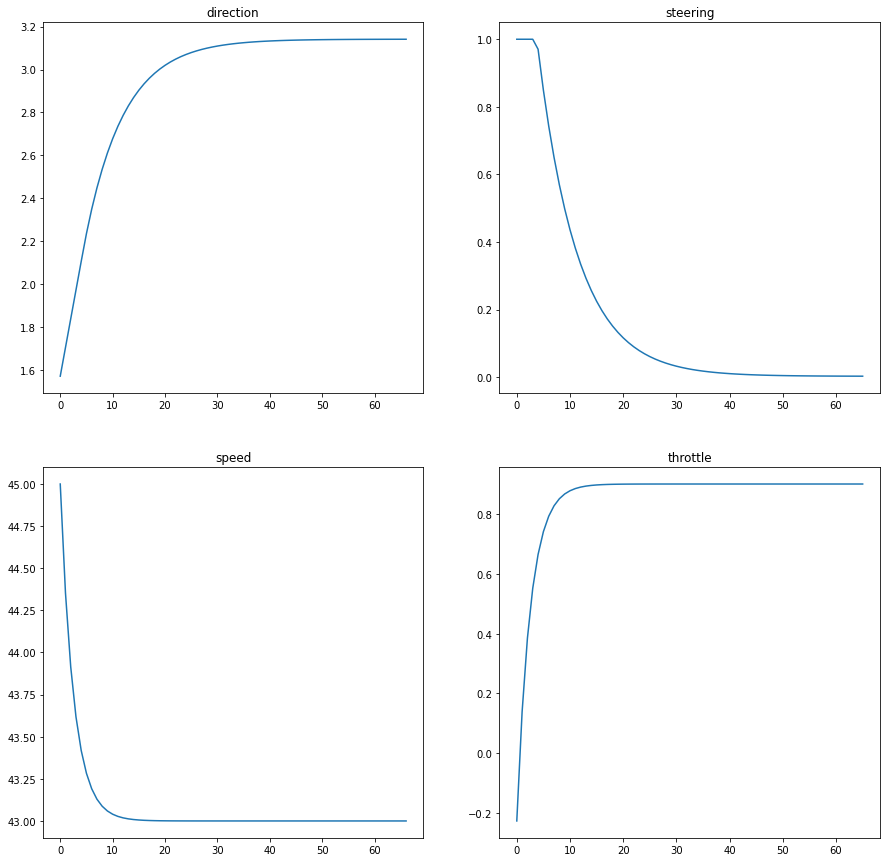

In [155]:
x0 = np.array([np.pi/2, 45])
xd = np.array([np.pi, 43])

x, u = simulate_control_2D(A, B, K, x0, xd)
plot_simulation_2D(x, u)

## thoughts

The angle looks fine, but the throttle looks unrealistic. It shows that even at full throttle, the car cannot reach 50 km/hr, but it has already done so during simulations, so I am unsure why this is the case. I'm guessing the decay term in the velocity (i.e. $1 - 0.9884$) is too large, but I don't think we really need to worry about it right now. Let's try to code up an agent and controller for it and go from there!